## TTA in Phosphorescent OLEDs

In [18]:
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 200
%matplotlib widget

coulomb = 1.60217662E-19
#plt.rcParams['figure.figsize'] = [8, 4]
experimental = np.loadtxt('experimental_PT0EP-CBP.txt')
x0 = experimental[0][0]
y0 = experimental[0][1]
xf = experimental[:,0][-1]

tau_t    = 65*1E-6                    # s
q        = 1*coulomb                  # electron charge 
d        = 100E-8                     # thickness of the exciton formation zone cm
k_tt     = 3E-14                      # cm^3/s
kappa_tt = 2.5E-32                    # cm^6/s
J0       = 0.8#1E3*4*q*d/(k_tt*tau_t**2)  # mA/cm^2
J        = np.linspace(x0,xf,2000) # Current density mA/cm^2


##### Analytic dexter tta ####
def tta_dexter_analytic(J):
    return (J0/(4*J))*(np.sqrt(1+8*(J/J0)) -1)
############################

##### Traditional Model ####
def tta_dexter(j): 
    # aT^2 + b*T + G*c = 0
    j = j*1E-3 #mA to A
    a = 1
    b = (2/(k_tt*tau_t))
    c = -(2/k_tt)
    G = j/(q*d)
    T = [x.real for x in np.roots([a,b,G*c]) if x.imag == 0 and x.real >=0][0]
    EFF = T/(G*tau_t)
    return EFF
############################


##### New Model ####
def tta_forster(j): 
    # aT^3 + 0*T^2 + b*T + G*c = 0
    j = j*1E-3 #mA to A
    a = -0.5*kappa_tt
    b = -1/tau_t
    c =  1
    G = j/(q*d)
    T = [x.real for x in np.roots([a,0,b,G*c]) if x.imag == 0 and x.real >=0][0]
    EFF = T/(G*tau_t)
    return EFF
############################

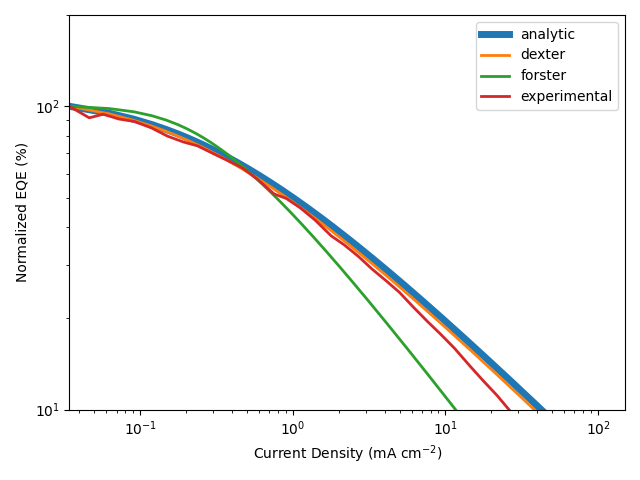

In [17]:
fig, ax = plt.subplots(1,1)

analytic = tta_dexter_analytic(J)
dexter   = np.array([tta_dexter(j) for j in J])
forster  = np.array([tta_forster(j) for j in J])


#normalizing the data
analytic = analytic/analytic[0]
dexter   = dexter/dexter[0]
forster  = forster/forster[0]
analytic = analytic/analytic[0]
y_exp    = experimental[:,1]/experimental[:,1][0]

ax.plot(J,100*analytic,label='analytic',lw=5)
ax.plot(J,100*dexter  ,label='dexter'  ,lw=2)
ax.plot(J,100*forster ,label='forster' ,lw=2)
ax.plot(experimental[:,0],100*y_exp ,label='experimental' ,lw=2)


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([x0, 150])
ax.set_ylim([10, 200])
ax.set_xlabel('Current Density (mA cm$^{-2}$)')
ax.set_ylabel('Normalized EQE (%)')
ax.legend()
plt.tight_layout()
plt.show()
